Import the libraries

In [1]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

visualization function

In [2]:
def view(tensor,ch = 1 , size = (28,28) , num = 16):
  data = tensor.detach().cpu().view(-1,ch,*size)
  grid = make_grid(data[:num], nrow = 4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()

setup of the main parameters and hyperparameters

In [5]:
n_epochs = 200
info_step = 108
cur_step = 0
mean_gen_loss = 0
mean_disc_loss = 0
bs = 128
lr = 0.0001
z_dim = 64
loss = nn.BCEWithLogitsLoss()
device = 'cuda'
data = DataLoader(MNIST('.', download = True , transform= transforms.ToTensor()), batch_size = bs , shuffle = True)

##declare our models




Generator

In [4]:
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(True)
  )

class Generator(nn.Module):
  def __init__(self,z_dim = 64 , h_dim  = 128 , target = 784):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim,  h_dim),
        genBlock(h_dim, h_dim * 2),
        genBlock(h_dim * 2 , h_dim * 4),
        genBlock(h_dim * 4 , h_dim * 8),
        genBlock(h_dim * 8 , h_dim * 4),
        nn.Linear(h_dim * 4 , target),
        nn.Sigmoid()
    )

  def forward(self,noise):
    return self.gen(noise)

Noise Gen function

In [6]:
def genNoise(num , z_dim):
  return torch.randn(num , z_dim).to(device)

Discriminator

In [8]:
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):

  def __init__(self,h_dim = 256, i_dim  = 784):
    super().__init__()
    self.disc = nn.Sequential(
        discBlock(i_dim , h_dim * 4),
        discBlock(h_dim * 4 , h_dim * 8),
        discBlock(h_dim * 8 ,h_dim * 4),
        discBlock(h_dim *4 , 1)
    )

  def forward(self,image):
    return self.disc(image)

define our models

In [16]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters() , lr = lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters() , lr = lr)

viewing smaple

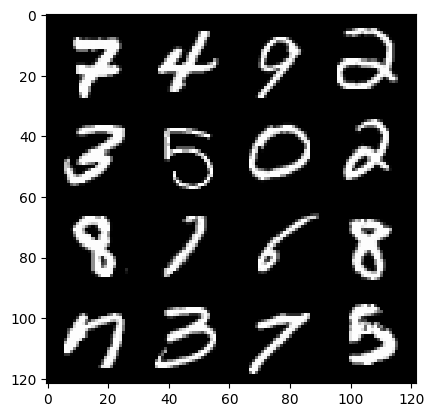

In [19]:
x,y = next(iter(data))
view(x)

##calculating the loss

Generator loss

In [10]:
def calc_gen_loss(loss_func,gen,disc,num,z_dim):
  noise = genNoise(num ,z_dim)
  fake = gen(noise)
  fake_disc_pred = disc(fake)
  fake_disc_target = torch.ones_like(fake_disc_pred)
  gen_loss = loss_func(fake_disc_pred,fake_disc_target)
  return gen_loss

Discriminator loss

In [15]:
def calc_disc_loss(loss_func,gen,disc,real,num,z_dim):
  noise = genNoise(num,z_dim)
  fake = gen(noise)
  fake_pred = disc(fake.detach())
  fake_target = torch.zeros_like(fake_pred)
  fake_loss = loss_func(fake_pred,fake_target)

  real_pred = disc(real)
  real_target = torch.ones_like(real_pred)
  real_loss = loss_func(real_pred,real_target)

  disc_loss = (fake_loss + real_loss)/2
  return disc_loss

# **Training our model**

 60000 / 128 = 468.75  = 469 steps in each epoch

 Each step is going to process 128 images = size of the batch (except the last step)


In [ ]:
for epoch in range(n_epochs):
  for real,_ in tqdm(data):
    #discriminator
    disc_opt.zero_grad()
    cur_bs = len(real)

    real = real.view(cur_bs , -1)
    real = real.to(device)
    disc_loss = calc_disc_loss(loss,gen,disc,real,cur_bs,z_dim)
    disc_loss.backward(retain_graph = True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph = True)
    gen_opt.step()

    mean_gen_loss += gen_loss.item() / info_step
    mean_disc_loss += disc_loss.item() / info_step

    if cur_step % info_step == 0 and cur_step > 0:
      noise = genNoise(cur_bs,z_dim)
      fake = gen(noise)
      view(fake)
      view(real)
      print(f"Epoch :{epoch} , Step :{cur_step} , Generator Loss :{mean_gen_loss} , Discriminator Loss :{mean_disc_loss}")
      mean_gen_loss,mean_disc_loss = 0,0
    cur_step += 1

